# 🚢 Titanic Estimator

6-step ML framework <a href="https://www.mrdbourke.com/a-6-step-field-guide-for-building-machine-learning-projects/">here</a>:

1️⃣ **Problem Definition:** What problem are we trying to solve? 

2️⃣ **Data:** What data do we have?

3️⃣ **Evaluation:** What defines success? What metric will we use to evaluate our model? 

4️⃣ **Features:** What features should we use?

5️⃣ **Model:** What model will weuse to solve the problem?

6️⃣ **Experimentation & Evaluation:** What have we tried and what else can we try?


### 1. Problem Definition

Predicting the surviving passengers of the Titanic shipwreck based on the features of the passengers.

### 2. Data

Data comes from <a href="https://www.kaggle.com/competitions/titanic/overview">Kaggle</a>. See the data dictionary for detailed descriptions of the features.

### 3. Evaluation

Accuracy of the model, evaluated when submitting to the Kaggle competition.

### 4. Features

In [353]:
# Data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing & validation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Data splitting & cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

In [354]:
# Set random seed
seed = 99
np.random.seed(seed)

In [355]:
# Load data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [356]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [357]:
# Split train_data into features (X) and labels (y)
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

# Split features and labels into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

In [358]:
# Data shapes
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((712, 11), (179, 11), (712,), (179,))

In [359]:
# Check missing labels
y_train.isna().sum(), y_valid.isna().sum()

(np.int64(0), np.int64(0))

In [360]:
# Check missing features
print("X_train.isna().sum()", X_train.isna().sum())
print("X_valid.isna().sum()", X_valid.isna().sum())

X_train.isna().sum() PassengerId      0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          547
Embarked         1
dtype: int64
X_valid.isna().sum() PassengerId      0
Pclass           0
Name             0
Sex              0
Age             33
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          140
Embarked         1
dtype: int64


In [361]:
# Impute missing values in categorical features with 'Unknown' and encode them
categorical_features = ["Sex", "Cabin", "Embarked", "Fare"]

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

In [362]:
# Impute missing values in 'Age' column with the median age
numeric_features = ["Age"]

numeric_transformer = Pipeline(steps=[
    ("missing_indicator", SimpleImputer(strategy="constant", add_indicator=True)),
    ("imputer", SimpleImputer(strategy="median"))])

In [363]:
# Create a preprocessor that drops Name and Ticket columns and then applies the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("drop_cols", "drop", ["Name", "Ticket"]),
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)],
    remainder="passthrough",
    force_int_remainder_cols=False)

### 5. Model

In [364]:
# Create script to evaluate multiple models
models = {"LinearSVC": LinearSVC(),
          "KNN": KNeighborsClassifier(),
          "SVC": SVC(),
          "LogisticRegression": LogisticRegression(max_iter=2500),
          "RandomForestClassifier": RandomForestClassifier()}

results = {}

for model_name, model in models.items():
    # Create pipeline
    clf = Pipeline(steps=[("preprocessor", preprocessor),
                          ("model", model)])
    # Fit the model to training data
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    results[model_name] = scores.mean()

for model_name, model_score in results.items():
    print(f"{model_name}: {model_score:.3f}")

LinearSVC: 0.833
KNN: 0.515
SVC: 0.612
LogisticRegression: 0.831
RandomForestClassifier: 0.808


In [365]:
# Instantiate the RFC model and fit it to the training data
clf = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", RandomForestClassifier())])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop_cols', 'drop',
                                                  ['Name', 'Ticket']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Cabin', 'Embarked',
                                                   'Fare']),
                                                 ('num',
                                                  Pipeline(steps=[('missing_indicator',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='constant')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age'])])),
                ('model', RandomForestClassifier())])

### 6. Experimentation & Evaluation

In [366]:
# Set up parameter space for RandomizedSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [10, 20, 30, 40, 50, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

rs_clf = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

rs_clf.fit(X_train, y_train)

print("Best parameters:", rs_clf.best_params_)
print("Best cross-validation score:", rs_clf.best_score_)

Best parameters: {'model__n_estimators': 400, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 30, 'model__bootstrap': True}
Best cross-validation score: 0.8230079779375554


In [367]:
# Make predictions and compute key eval metrics
y_preds = rs_clf.predict(X_valid)

print("Validation metrics:")
print(f"Accuracy: {accuracy_score(y_valid, y_preds):.3f}") # proportion of correct predictions
print(f"Precision: {precision_score(y_valid, y_preds):.3f}") # proportion of positive identifications (model predicted class 1) which were actually correct
print(f"Recall: {recall_score(y_valid, y_preds):.3f}") # proportion of actual positives which were correctly identified by the model
print(f"F1 score: {f1_score(y_valid, y_preds):.3f}") # harmonic mean of precision and recall

Validation metrics:
Accuracy: 0.816
Precision: 0.811
Recall: 0.652
F1 score: 0.723


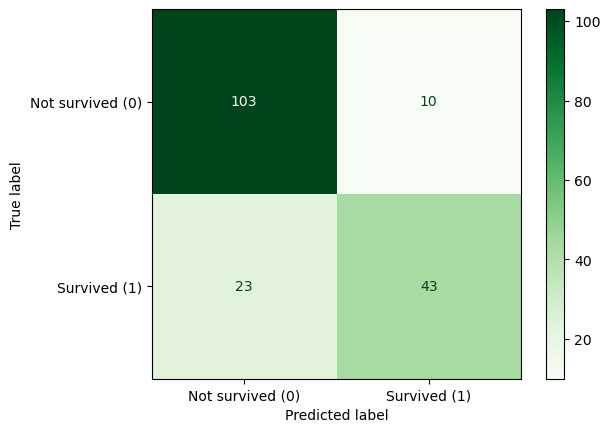

In [368]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    estimator=rs_clf, 
    X=X_valid, 
    y=y_valid, 
    display_labels=["Not survived (0)", "Survived (1)"],
    cmap=plt.cm.Greens
);

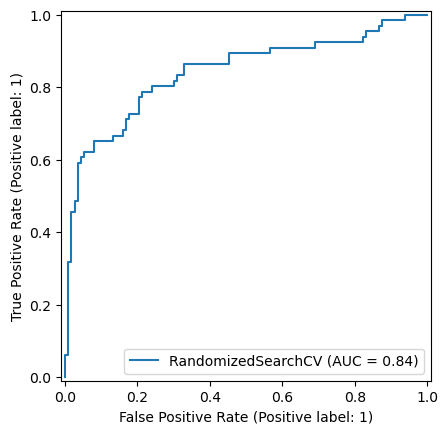

In [369]:
# Plot ROC curve
RocCurveDisplay.from_estimator(rs_clf, X_valid, y_valid);

### Exporting predictions

In [370]:
# Make final predictions
final_predictions = rs_clf.predict(test_df)

In [371]:
# Export predictions to CSV
predictions_df = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": final_predictions})
predictions_df.to_csv("titanic_predictions.csv", index=False)